# **Stock Market Prediction - Baseline Models**

In this notebook some baseline models are tested to do one-day ahead prediction.Different combination of sequence lenght and stack GRU cell layers are used.


# **Load libraries and data**

In [58]:
# Load libraries
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import datetime
from sklearn.linear_model import LinearRegression

# Set seed to reproducibility
random.seed(55)

In [2]:
 # Load data
 data = pd.read_csv('AAPL.csv')  
 # Convert Date to Date format
 data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d')

# Crop data to use stock values from 2006 onwards
data = data[data.Date>=datetime.datetime(2006,1,1)]

# Visualization of our data
data.head()

,Date,Open,High,Low,Close,Adj Close,Volume
6323,2006-01-03,10.340000,10.678572,10.321428,10.678572,9.269435,201808600
6324,2006-01-04,10.732857,10.854285,10.642858,10.710000,9.296719,154900900
6325,2006-01-05,10.690000,10.700000,10.535714,10.625714,9.223555,112355600
6326,2006-01-06,10.750000,10.957143,10.650000,10.900000,9.461646,176114400
6327,2006-01-09,10.961429,11.028571,10.820000,10.864285,9.430640,168760200


In [3]:
# Split data in training and test
data_train = data[data.Date<datetime.datetime(2019,1,1)]
data_test = data[data.Date>=datetime.datetime(2019,1,1)]

In [4]:
# For prediction, we go to use a window slice of different lenght. 
# We go to start with 20 samples (Open[0] to Open[19]). In this way, we can 
# predict the value 21 (Open[20]) and for next iteration, we take values
# Open[20] to Open[39] to predict Open[40] and so on.

# Now, first, we go to normalize data in a range of 0 to 1.

# Define min max scaler
scaler = MinMaxScaler(feature_range=(0,1))

# Scale data
data_train['Scaled Open'] = scaler.fit_transform(data_train[['Open']])
# Also, scale test data
data_test['Scaled Open'] = scaler.transform(data_test[['Open']])

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if sys.path[0] == '':
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


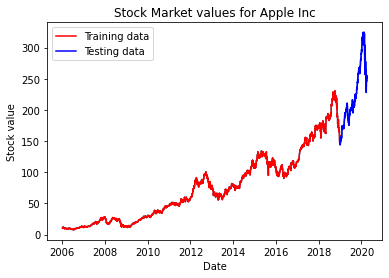

In [5]:
# Now, we go to check Open value in a plot 
plt.plot(data['Date'],data['Open'])
plt.plot(data_train['Date'],data_train['Open'],label = 'Training data', color='red')
plt.plot(data_test['Date'],data_test['Open'],label = 'Testing data', color='blue')
plt.xlabel('Date')
plt.ylabel('Stock value')
plt.title('Stock Market values for Apple Inc')
plt.legend()
plt.show()

In [6]:
# Extract data
train_values =  data_train[['Date','Scaled Open']]
test_values =  data_test[['Date','Scaled Open']]

# **Linear regression model**

In [74]:
# Define a sequence length
sequence_length = 15

# We go to create an array with our X and y values
previous_days_train = []
current_day_train = []

for x in range(len(train_values)-sequence_length):
  previous_days_train.append(train_values[['Scaled Open']][x:x+sequence_length].values)
  current_day_train.append(train_values[['Scaled Open']].values[x+sequence_length])

previous_days_train = np.array(previous_days_train)
previous_days_train = np.reshape(previous_days_train,(-1,sequence_length))

current_day_train = np.array(current_day_train)
current_day_train = current_day_train.reshape((-1))

In [115]:
current_day_train[0]

0.016409484572243074

In [116]:
previous_days_train[0]

array([0.01320561, 0.01496422, 0.01477237, 0.01504096, 0.01598742,
       0.01568046, 0.02053424, 0.02125687, 0.02126966, 0.0217237 ,
       0.02004822, 0.01887794, 0.01761813, 0.01558453, 0.01728559])

In [75]:
# We go to create an array with our X and y values
previous_days_test = []
current_day_test = []

for x in range(len(test_values)-sequence_length):
  previous_days_test.append(test_values[['Scaled Open']][x:x+sequence_length].values)
  current_day_test.append(test_values[['Scaled Open']].values[x+sequence_length])

previous_days_test = np.array(previous_days_test)
previous_days_test = np.reshape(previous_days_test,(-1,sequence_length))

current_day_test = np.array(current_day_test)
current_day_test = current_day_test.reshape((-1))

In [76]:
reg_model = LinearRegression().fit(previous_days_train, current_day_train)

In [77]:
pred_training =  reg_model.predict(previous_days_train)
pred_testing  =  reg_model.predict(previous_days_test)

In [113]:
# Getting MAE
error_mean_train = round(np.mean(abs(data_train[['Open']][sequence_length:].values- scaler.inverse_transform(pred_training.reshape(-1, 1)))),2)
print('Mean Absolute Error in training: ', str(error_mean_train))
error_mean_test = round(np.mean(abs(scaler.inverse_transform(pred_testing.reshape(-1, 1))- data_test[['Open']][sequence_length:].values)),2)
print('Mean Absolute Error in testing: ', str(error_mean_test))

Mean Absolute Error in training:  0.94
Mean Absolute Error in testing:  3.2


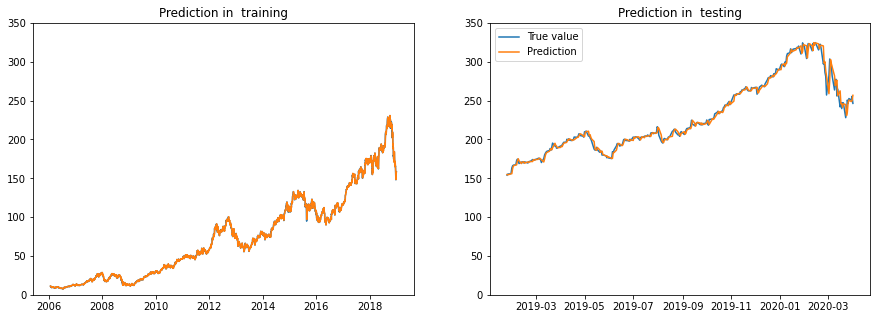

In [103]:
# Plot prediction
figure, axis = plt.subplots(1, 2,figsize=(15, 5))
axis[0].plot(data_train['Date'][sequence_length:],data_train['Open'][sequence_length:],label = 'True value')
axis[0].plot(data_train['Date'][sequence_length:],scaler.inverse_transform(pred_training.reshape(-1, 1)),label = 'Prediction')
axis[0].set_title("Prediction in  training")
axis[0].set_ylim(0,350)
axis[1].plot(data_test['Date'][sequence_length:],data_test['Open'][sequence_length:],label = 'True value')
axis[1].plot(data_test['Date'][sequence_length:],scaler.inverse_transform(pred_testing.reshape(-1, 1)),label = 'Prediction')
axis[1].set_title("Prediction in  testing")
axis[1].set_ylim(0,350)
plt.legend(loc = 'upper left')
plt.show()

# **ARIMA**

In [114]:
from statsmodels.tsa.arima.model import ARIMA
model = ARIMA(data_train['Scaled Open'], order=(5,1,80))
model_fit = model.fit(method_kwargs={"warn_convergence": False})
prediction_arima = model_fit.predict(start = len(data_train),end = len(data_train)+ len(data_test[sequence_length:])-1)

/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/base/tsa_model.py:579: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  ' ignored when e.g. forecasting.', ValueWarning)


KeyboardInterrupt: ignored

In [ ]:
# Plot predictions
plt.plot(data_test['Date'][sequence_length:],data_test['Scaled Open'][sequence_length:])
plt.plot(data_test['Date'][sequence_length:],prediction_arima)